In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABLES = ["Normal", "Fraud"]

In [2]:
credit_card = pd.read_csv('/content/creditcard.csv', sep=',')
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [3]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93181 entries, 0 to 93180
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    93181 non-null  int64  
 1   V1      93181 non-null  float64
 2   V2      93181 non-null  float64
 3   V3      93181 non-null  float64
 4   V4      93181 non-null  float64
 5   V5      93181 non-null  float64
 6   V6      93181 non-null  float64
 7   V7      93181 non-null  float64
 8   V8      93181 non-null  float64
 9   V9      93181 non-null  float64
 10  V10     93181 non-null  float64
 11  V11     93181 non-null  float64
 12  V12     93181 non-null  float64
 13  V13     93180 non-null  float64
 14  V14     93180 non-null  float64
 15  V15     93180 non-null  float64
 16  V16     93180 non-null  float64
 17  V17     93180 non-null  float64
 18  V18     93180 non-null  float64
 19  V19     93180 non-null  float64
 20  V20     93180 non-null  float64
 21  V21     93180 non-null  float64
 22

In [4]:
credit_card.shape

(93181, 31)

In [5]:
credit_card.isnull().values.any()

True

Text(0, 0.5, 'Frequency')

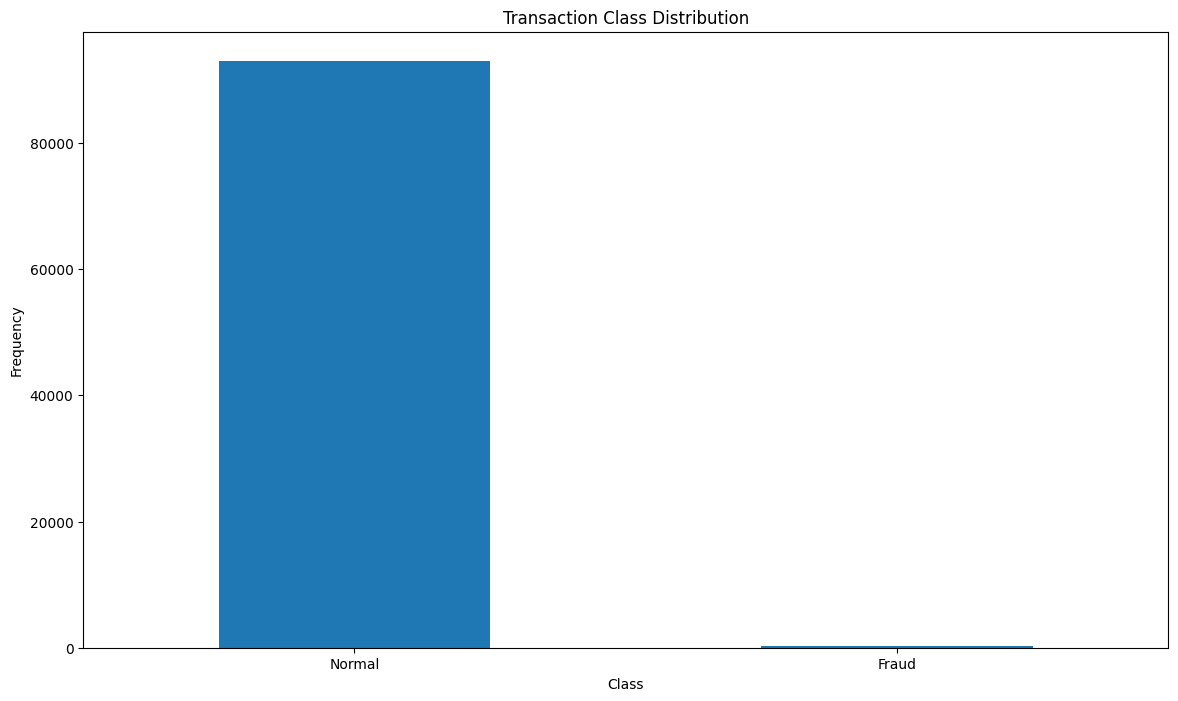

In [6]:
count_classes = pd.value_counts(credit_card['Class'], sort = True)
count_classes.plot(kind='bar', rot =0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2),LABLES)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
fraud = credit_card[credit_card['Class']==1]
normal = credit_card[credit_card['Class']==0]

In [8]:
print(fraud.shape,normal.shape)

(213, 31) (92967, 31)


In [9]:
fraud.Amount.describe()

count     213.000000
mean      108.459202
std       242.266755
min         0.000000
25%         1.000000
50%         7.610000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    92967.000000
mean        99.009344
std        268.408062
min          0.000000
25%          7.610000
50%         26.970000
75%         89.950000
max      19656.530000
Name: Amount, dtype: float64

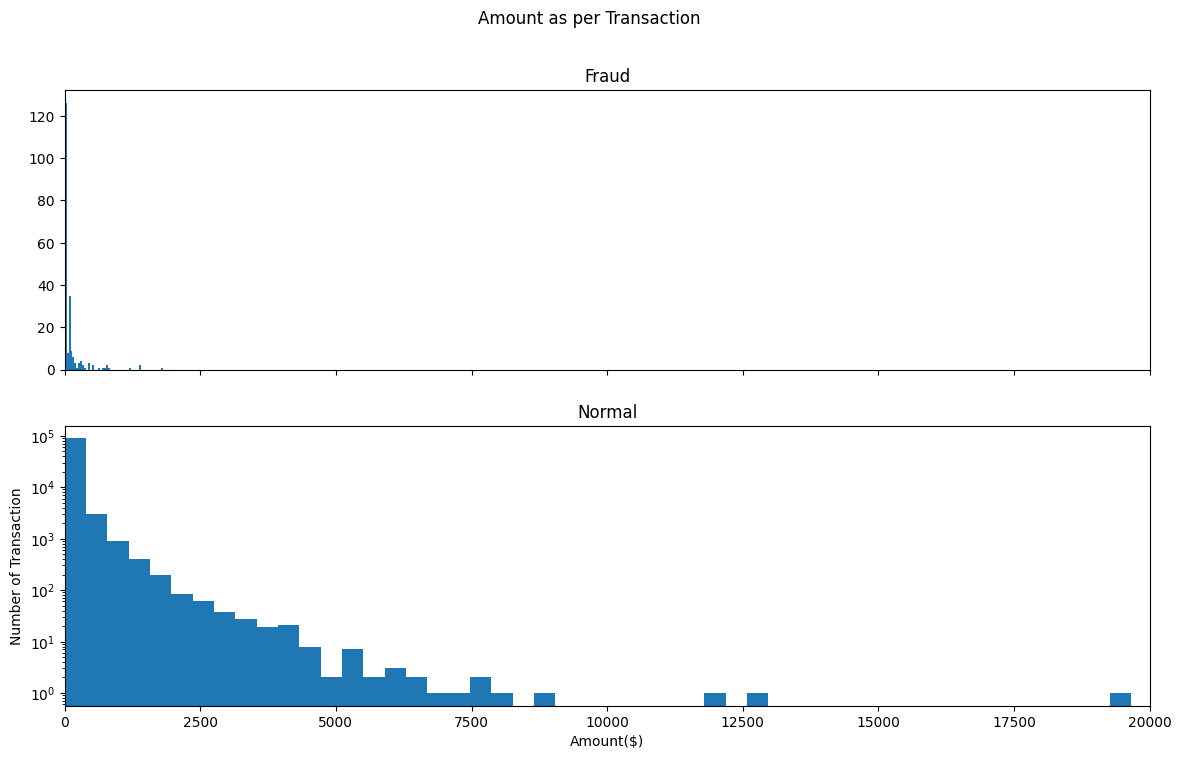

In [11]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Amount as per Transaction')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount($)')
plt.ylabel('Number of Transaction')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

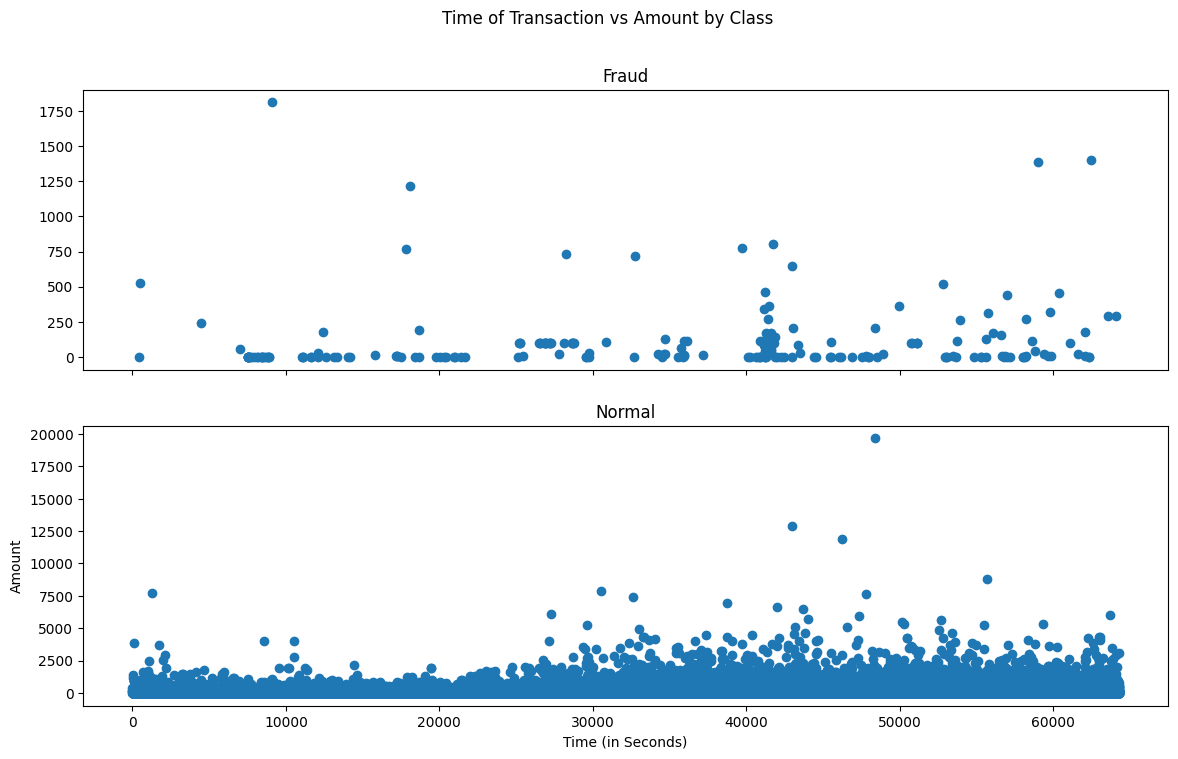

In [12]:

f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Time of Transaction vs Amount by Class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time,normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [13]:
credit = credit_card.sample(frac = 0.1, random_state=1)
credit.shape

(9318, 31)

In [14]:
from matplotlib.colors import Normalize
# Number of fraud and valid transaction in the dataset
Fraud = credit[credit['Class']==1]
valid = credit[credit['Class']==0]
outlier_function = len(Fraud)/float(len(valid))

In [15]:
print(outlier_function)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(valid)))

0.0012894906511927789
Fraud Cases : 12
Valid Cases : 9306


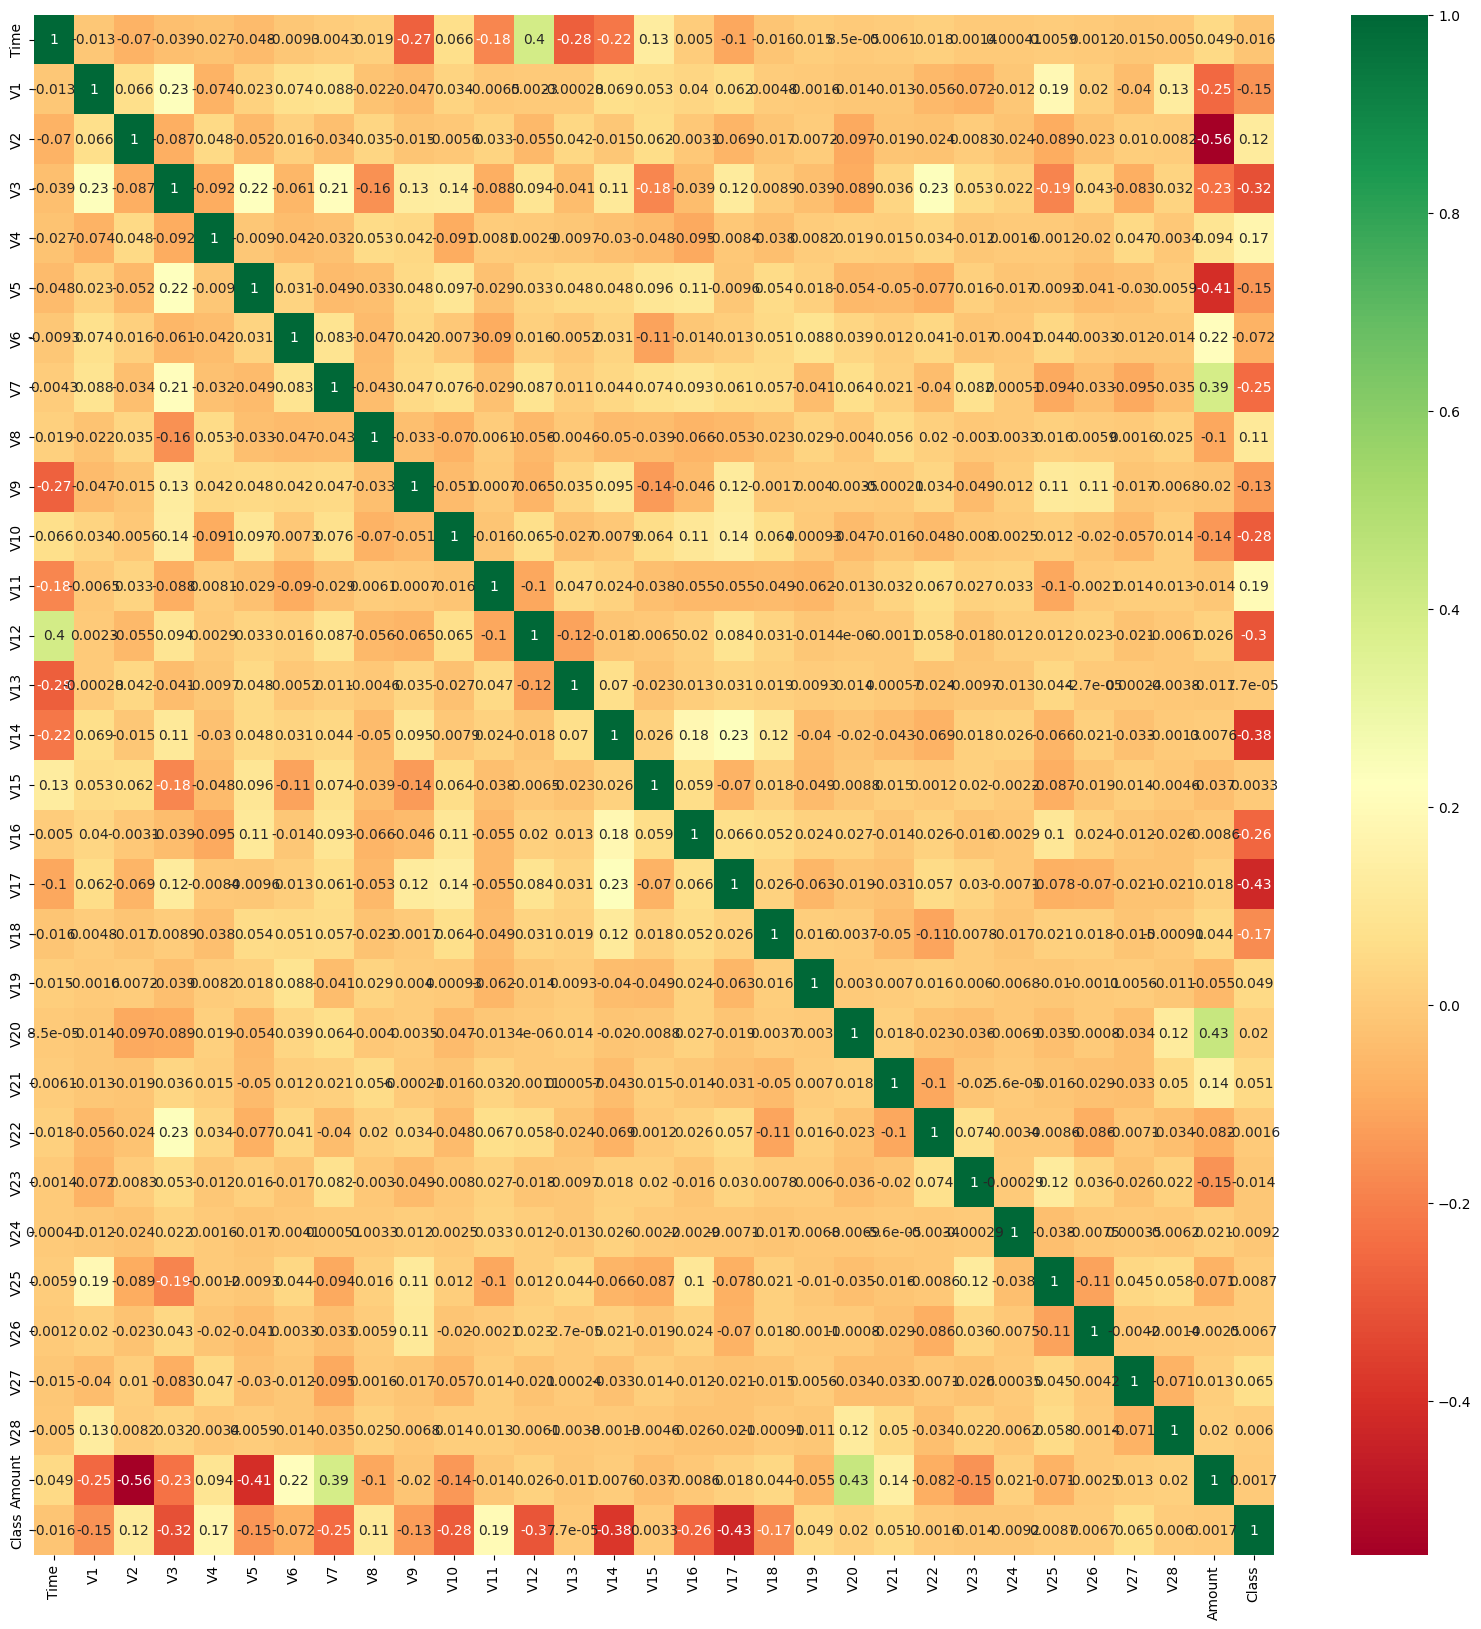

In [16]:
cormat = credit.corr()
top_corr_features = cormat.index
plt.figure(figsize=(20,20))

g = sns.heatmap(credit_card[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [17]:
columns = credit.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
target = "Class"
state = np.random.RandomState(42)
X = credit[columns]
Y = credit[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(9318, 30)
(9318,)


In [18]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),contamination=outlier_function,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20,algorithm="auto",leaf_size=30,metric='minkowski',p=2, metric_params=None,contamination=outlier_function),
    "Support vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, max_iter=-1)
}

In [19]:

type(classifiers)

dict

In [20]:
n_outliers=len(Fraud)
for i,(clf_name,clf) in enumerate(classifiers.items()):
  if clf_name == "Local Outlier Factor":
    y_pred = clf.fit_predict(X)
    scores_prediction = clf.negative_outlier_factor_
  elif clf_name == "Support Vector Machine":
    clf.fit(X)
    y_pred = clf.predit(X)
  else:
    clf.fit(X)
    scores_prediction = clf.decision_function(X)
    y_pred = clf.predict(X)
  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] =-1
  n_errors = (y_pred != Y).sum()

  print("{}: {}".format(clf_name,n_errors))
  print("Accuracy Score :")
  print(accuracy_score(Y,y_pred))
  print("Classification Report :")
  print(classification_report(Y,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 21
Accuracy Score :
0.9977462974887314
Classification Report :
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       1.00      1.00      1.00      9306
         1.0       0.00      0.00      0.00        12

    accuracy                           1.00      9318
   macro avg       0.33      0.33      0.33      9318
weighted avg       1.00      1.00      1.00      9318



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Local Outlier Factor: 25
Accuracy Score :
0.9973170208199185
Classification Report :
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       1.00      1.00      1.00      9306
         1.0       0.00      0.00      0.00        12

    accuracy                           1.00      9318
   macro avg       0.33      0.33      0.33      9318
weighted avg       1.00      1.00      1.00      9318



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Support vector Machine: 2794
Accuracy Score :
0.7001502468340846
Classification Report :
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       1.00      0.70      0.82      9306
         1.0       0.00      0.00      0.00        12

    accuracy                           0.70      9318
   macro avg       0.33      0.23      0.27      9318
weighted avg       1.00      0.70      0.82      9318



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.